RUN SBI-SGM in alpha, new bounds, new SGM, only three parameters needed

parameters order is  :tauG,speed,alpha (In second)


In [1]:
run_python_script = False

False

## Import some pkgs

In [2]:
import sys
sys.path.append("../../mypkg")

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict

In [3]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [4]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch

## Some fns

In [5]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

<function __main__.<lambda>(x)>

In [6]:
# transfer vec to a sym mat
def vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

In [7]:
def get_mode(x):
    kde_est = scipy.stats.gaussian_kde(x)
    xs = np.linspace(x.min(), x.max(), 500)
    ys = kde_est(xs)
    return xs[np.argmax(ys)]

### Some parameters

In [8]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# PSD
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values;

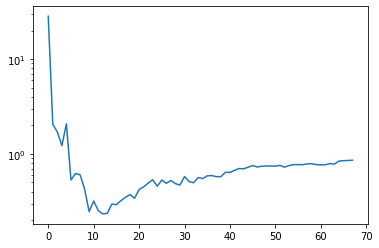

In [9]:
from scipy.io import loadmat
# The array is ordered as in ‘alpha’, ‘beta_l’, ‘delta’, ‘theta’
diag_ws = loadmat(DATA_ROOT/"diagonal_UFU.mat")["prjctFC_diag"];
diag_ws = np.abs(diag_ws).mean(axis=(1, 2))
#diag_ws = np.ones(82)
#diag_ws[0] = 1 # remove it
# normalized diag_ws (to mean 1 or max 1) (on May 10, 2023)
# or log(ws/min(ws)) still remove the first term (on May 10, 2023)
if not run_python_script:
    plt.plot(diag_ws)
    plt.yscale("log")

In [10]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]

In [11]:
paras = edict()

paras.fc_type = "alpha" #stick to coh
paras.freqrange =  np.linspace(_paras[paras.fc_type][0], _paras[paras.fc_type][1], 5)
paras.diag_ws = diag_ws
print(paras.freqrange)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
#paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
#paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
#paras.names = ["Taue", "Taui", "TauC", "Speed", "alpha", "gii", "gei"]
paras.par_low = np.asarray([0.005, 5, 0.1])
paras.par_high = np.asarray([0.03, 20, 1])
paras.names = ["TauC", "Speed", "alpha"]
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10
paras.add_v = 0.01

paras.SBI_paras = edict()
paras.SBI_paras.num_prior_sps = int(1e3)
paras.SBI_paras.density_model = "nsf"
paras.SBI_paras.num_round = 1 # 3
paras.SBI_paras.noise_sd = 0.2
print(paras.diag_ws)

[ 8.  9. 10. 11. 12.]
[28.34730666  2.04960239  1.70749507  1.22529579  2.07701591  0.53111972
  0.6218343   0.60427364  0.42565082  0.24645076  0.31900365  0.25322547
  0.23310096  0.23638545  0.29637963  0.29173875  0.32172899  0.34877173
  0.37271771  0.3407041   0.42165469  0.44977377  0.49267775  0.53535327
  0.45689171  0.5307152   0.49010218  0.52487552  0.48627499  0.47017923
  0.57866959  0.51133174  0.49745823  0.56322006  0.55008061  0.58736851
  0.5917356   0.57619634  0.57585997  0.64097135  0.63919469  0.67089503
  0.70194127  0.69713099  0.72477668  0.75575609  0.72799299  0.74255208
  0.74701997  0.74549816  0.74341354  0.75704742  0.72661308  0.7535987
  0.77213942  0.77174635  0.76942024  0.78661123  0.78909111  0.7723603
  0.76788512  0.76919267  0.79200622  0.78210296  0.84090921  0.84930545
  0.85326197  0.85928982]


In [12]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=0.1)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=0.1))

functools.partial(<function theta_raw_2out at 0x7f2b9f4343a0>, map_fn=functools.partial(<function logistic_np at 0x7f2b9f434310>, k=0.1))

### Load the data

In [13]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.max(cur_ind_conn)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn

if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))

Add 0.01 on diag


In [14]:
# Load true MEG FC time series:
dataPath = DATA_ROOT/f'./MEG_FC_{paras.fc_type}_DK_networks_coh.mat'
data = loadmat(dataPath);
true_FC = data[f"MEG_{paras.fc_type}_FC_networks_coh"]
true_FC.shape

(68, 68, 36)

In [47]:
def network_transfer_local_fc_alpha_new(brain, parameters, w, diag_ws):
    """Network Transfer Function for spectral graph model.

    Args:
        brain (Brain): specific brain to calculate NTF
        parameters (dict): parameters for ntf. We shall keep this separate from Brain
               for now, as we want to change and update according to fitting.
        frequency (float): frequency at which to calculate NTF

    Returns:
        fc(numpy asarray):  The FC for the given frequency (w)
    """
    # remove the following idxs
    rm_idxs = [68, 76, 77, 85]
    
    C = brain.reducedConnectome
    D = brain.distance_matrix
    
    C = np.delete(C, rm_idxs, axis=0)
    C = np.delete(C, rm_idxs, axis=1)
    D = np.delete(D, rm_idxs, axis=0)
    D = np.delete(D, rm_idxs, axis=1)

    speed = parameters["speed"]
    tauC = parameters["tauC"]
    alpha = parameters["alpha"]
    
    # Defining some other parameters used:
    zero_thr = 0.01

    # define sum of degrees for rows and columns for laplacian normalization
    rowdegree = np.transpose(np.sum(C, axis=1))
    coldegree = np.sum(C, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf

    nroi = C.shape[0]

    K = nroi

    Tau = 0.001 * D / speed
    Cc = C * np.exp(-1j * Tau * w)

    # Eigen Decomposition of Complex Laplacian Here
    L1 = np.identity(nroi)
    L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    L = L1 - alpha * np.matmul(np.diag(L2), Cc)

    d, v = np.linalg.eig(L)  
    eig_ind = np.argsort(np.abs(d))  # sorting in ascending order and absolute value
    eig_vec = v[:, eig_ind]  # re-indexing eigen vectors according to sorted index
    eig_val = d[eig_ind]  # re-indexing eigen values with same sorted index

    eigenvalues = np.transpose(eig_val)
    eigenvectors = eig_vec[:, 0:K]

    # Cortical model
    FG = np.divide(1 / tauC ** 2, (1j * w + 1 / tauC) ** 2)


    q1 = (1j * w + 1 / tauC * FG * eigenvalues)
    qthr = zero_thr * np.abs(q1[:]).max()
    magq1 = np.maximum(np.abs(q1), qthr)
    angq1 = np.angle(q1)
    q1 = np.multiply(magq1, np.exp(1j * angq1))
    frequency_response = np.divide(diag_ws, np.abs(q1)**2)
    
    fc = 0
    for k in range(K):
        fc += (frequency_response[k]) * np.outer(eigenvectors[:, k], np.conjugate(eigenvectors[:, k]))
    # get FC
    fc = np.abs(fc)

    return fc


In [55]:
def network_transfer_local_fc_alpha_new1(brain, parameters, w, diag_ws):
    """Network Transfer Function for spectral graph model.

    Args:
        brain (Brain): specific brain to calculate NTF
        parameters (dict): parameters for ntf. We shall keep this separate from Brain
               for now, as we want to change and update according to fitting.
        frequency (float): frequency at which to calculate NTF

    Returns:
        fc(numpy asarray):  The FC for the given frequency (w)
    """
    # remove the following idxs
    rm_idxs = [68, 76, 77, 85]
    
    C = brain.reducedConnectome
    D = brain.distance_matrix
    
    C = np.delete(C, rm_idxs, axis=0)
    C = np.delete(C, rm_idxs, axis=1)
    D = np.delete(D, rm_idxs, axis=0)
    D = np.delete(D, rm_idxs, axis=1)

    speed = parameters["speed"]
    tauC = parameters["tauC"]
    alpha = parameters["alpha"]
    
    # Defining some other parameters used:
    zero_thr = 0.01

    # define sum of degrees for rows and columns for laplacian normalization
    rowdegree = np.transpose(np.sum(C, axis=1))
    coldegree = np.sum(C, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf

    nroi = C.shape[0]
    K = nroi

    Tau = 0.001 * D / speed
    Cc = C * np.exp(-1j * Tau * w)

    # Eigen Decomposition of Complex Laplacian Here
    L1 = np.identity(nroi)
    L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    L = L1 - alpha * np.matmul(np.diag(L2), Cc)

    d, v = np.linalg.eig(L)  
    eig_ind = np.argsort(np.abs(d))  # sorting in ascending order and absolute value
    eig_vec = v[:, eig_ind]  # re-indexing eigen vectors according to sorted index
    eig_val = d[eig_ind]  # re-indexing eigen values with same sorted index

    eigenvalues = np.transpose(eig_val[:K])
    eigenvectors = eig_vec[:, :K]

    # Cortical model
    FG = np.divide(1 / tauC ** 2, (1j * w + 1 / tauC) ** 2)


    q1 = (1j * w + 1 / tauC * FG * eigenvalues)
    qthr = zero_thr * np.abs(q1[:]).max()
    magq1 = np.maximum(np.abs(q1), qthr)
    angq1 = np.angle(q1)
    q1 = np.multiply(magq1, np.exp(1j * angq1))
    frequency_response = np.divide(diag_ws, np.abs(q1)**2)
    
    fc = eigenvectors @ np.diag(frequency_response) @ np.conjugate(eigenvectors.T)
    fc = np.abs(fc)

    return fc


In [56]:
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [57]:
paras.prior_bds

array([[5.e-03, 3.e-02],
       [5.e+00, 2.e+01],
       [1.e-01, 1.e+00]])

In [61]:
diag_ws = np.ones(82)
w = 2*np.pi*1
params = edict()
params.tauC = 1e-2
params.speed = 10
params.alpha = 5e-1

In [62]:
FC1 = network_transfer_local_fc_alpha_new(brain, params, w, diag_ws)
FC2 = network_transfer_local_fc_alpha_new1(brain, params, w, diag_ws)
np.linalg.norm(FC1 - FC2)

6.491778646022333e-19

4.953178584091276e-18